In [1]:
import pandas as pd
import numpy as np

In [2]:
data=pd.read_csv('AAPL.csv') #Stock market data of apple 

In [3]:
data.head()

,Unnamed: 0,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,0,AAPL,2015-05-27 00:00:00+00:00,132.045,132.260,130.05,130.34,45833246,121.682558,121.880685,119.844118,120.111360,45833246,0.0,1.0
1,1,AAPL,2015-05-28 00:00:00+00:00,131.780,131.950,131.10,131.86,30733309,121.438354,121.595013,120.811718,121.512076,30733309,0.0,1.0
2,2,AAPL,2015-05-29 00:00:00+00:00,130.280,131.450,129.90,131.23,50884452,120.056069,121.134251,119.705890,120.931516,50884452,0.0,1.0
3,3,AAPL,2015-06-01 00:00:00+00:00,130.535,131.390,130.05,131.20,32112797,120.291057,121.078960,119.844118,120.903870,32112797,0.0,1.0
4,4,AAPL,2015-06-02 00:00:00+00:00,129.960,130.655,129.32,129.86,33667627,119.761181,120.401640,119.171406,119.669029,33667627,0.0,1.0


<AxesSubplot:>

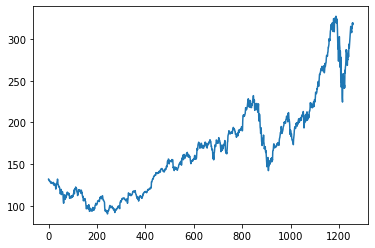

In [4]:
y = data['close']
y.index=data.index
y.plot()

In [5]:
# Convert Pandas series to numpy ndarray for further processing.
y = y.values

In [6]:
# Split data into trainning and testing using 80/20 ratio.
training_size = int(y.size * 0.8)
print(training_size)

1006


In [7]:
# Data normalization using training data's mean and standard deviation.
# y is a ndarray now and its dimension is 1.
training_mean = y[:training_size].mean()
training_std = y[:training_size].std()
# standarize the data
y = (y-training_mean)/training_std

In [8]:
# Take a look at the training data
y[0:5]

array([-0.39727421, -0.40449243, -0.44535032, -0.43840448, -0.45406667])

In [9]:
# Define a function to prepare data.
# The time series data are reorganized to form feature vectors and target values.
# For example, let sHistory be 10. A datapoint as a target will have 10 immediately 
# previous 10 values in the time series for its feature vector. 
def data_preprocess(dataset, iStart, iEnd, sHistory):
  data = []
  target = []
  # begin with sHistory to have historical data
  iStart += sHistory
  if iEnd is None:
    iEnd = len(dataset)
  for i in range(iStart, iEnd):
    indices = range(i-sHistory, i)
    data.append(np.reshape(dataset[indices], (sHistory, 1)))
    target.append(dataset[i])
  return np.array(data), np.array(target)

In [10]:
# Let's define number of history data for training and split data into training nd testing datasets.
past_history = 10
xtrain, ytrain = data_preprocess(y, 0, training_size, past_history)
xtest, ytest = data_preprocess(y, training_size, None, past_history)

In [11]:
# Take a look at data.
xtest[0]

array([[0.88089678],
       [0.86074022],
       [0.83758742],
       [0.86264692],
       [0.77466627],
       [0.72645396],
       [0.89914664],
       [0.97813856],
       [1.05113799],
       [1.18542425]])

In [12]:
# Take a look at data.
xtest[1]

array([[0.86074022],
       [0.83758742],
       [0.86264692],
       [0.77466627],
       [0.72645396],
       [0.89914664],
       [0.97813856],
       [1.05113799],
       [1.18542425],
       [1.25161404]])

In [13]:
# It's time to get Tensorflow library in and create an LSTM model.
import tensorflow as tf
# Setting seed to ensure reproducibility.
tf.random.set_seed(8888)
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(8, input_shape=xtrain.shape[-2:]),
  tf.keras.layers.Dense(1)
])

In [14]:
def calculate_mape(y_true, y_pred): 
    """
    Calculate the Mean Absolute Percentage Error (MAPE) %
    """
    y_pred, y_true = np.array(y_pred), np.array(y_true)    
    mape = np.mean(np.abs((y_true-y_pred) / y_true))*100    
    return mape

In [15]:
# Before taining, you need to configure the model for training.
model.compile(optimizer='Adam',loss='mse')

In [16]:
BATCH_SIZE = 16
BUFFER_SIZE = 10000

p_train = tf.data.Dataset.from_tensor_slices((xtrain, ytrain))
p_train = p_train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

p_test = tf.data.Dataset.from_tensor_slices((xtest, ytest))
p_test = p_test.batch(BATCH_SIZE).repeat()

In [17]:
# For your model to be able to predict something, your need to train your model using training data.
history = model.fit(p_train, epochs = 10, steps_per_epoch=200, validation_data=p_test, validation_steps=50)

Epoch 1/10
200/200 [==============================] - 2s 5ms/step - loss: 0.1715 - val_loss: 3.1751
Epoch 2/10
200/200 [==============================] - 1s 3ms/step - loss: 0.0261 - val_loss: 1.9070
Epoch 3/10
200/200 [==============================] - 1s 3ms/step - loss: 0.0143 - val_loss: 1.3256
Epoch 4/10
200/200 [==============================] - 1s 3ms/step - loss: 0.0103 - val_loss: 1.0941
Epoch 5/10
200/200 [==============================] - 1s 3ms/step - loss: 0.0092 - val_loss: 0.9042
Epoch 6/10
200/200 [==============================] - 1s 3ms/step - loss: 0.0085 - val_loss: 0.7842
Epoch 7/10
200/200 [==============================] - 1s 3ms/step - loss: 0.0080 - val_loss: 0.7447
Epoch 8/10
200/200 [==============================] - 1s 3ms/step - loss: 0.0074 - val_loss: 0.6763
Epoch 9/10
200/200 [==============================] - 1s 3ms/step - loss: 0.0076 - val_loss: 0.6130
Epoch 10/10
200/200 [==============================] - 1s 4ms/step - loss: 0.0070 - val_loss: 0.5526

In [18]:
# Convert training history to datafram for viewing and graphing.
hist = pd.DataFrame(history.history)
hist.head()

,loss,val_loss
0,0.171471,3.175051
1,0.026144,1.907029
2,0.014251,1.325554
3,0.010288,1.094132
4,0.009214,0.904237


In [19]:
# Now, we can predict stock values after model is trained. 
# We keep the predicted values and target vlaues for graphics later.
# You may run on p_train or p_test to check the preformance.
predicted_value = []
y_orig = []
count =0;
for x, y in p_train.take(20):
  y_orig.append(y[0].numpy())
  t_pred= model.predict(x)
  predicted_value.append(t_pred[0])

<AxesSubplot:>

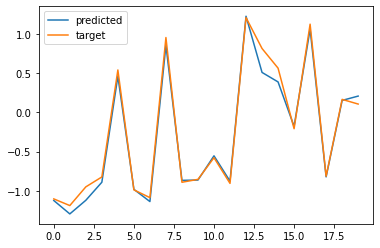

In [20]:
# Plot the predicted value and the target values together.
y_pred = [predicted_value[i][0] for i in range(len(predicted_value))]
result = pd.DataFrame({'predicted':y_pred, 'target':y_orig})
result.plot()

In [21]:
# Now, we can predict stock values after model is trained. 
# We keep the predicted values and target vlaues for graphics later.
# You may run on p_train or p_test to check the preformance.
predicted_value = []
y_orig = []
count =0;
for x, y in p_test.take(20):
  y_orig.append(y[0].numpy())
  t_pred= model.predict(x)
  predicted_value.append(t_pred[0])

<AxesSubplot:>

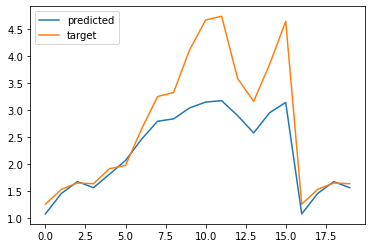

In [22]:
# Plot the predicted value and the target values together.
y_pred = [predicted_value[i][0] for i in range(len(predicted_value))]
result = pd.DataFrame({'predicted':y_pred, 'target':y_orig})
result.plot()